In [1]:
# Loading libraries for the course
import random
import matplotlib.pyplot as plt             # Library used for plotting
from matplotlib.patches import Rectangle    # Module to plot a rectangle in the image
import urllib.request                       # Library to download data
import numpy as np                          # Library for array manipulation
import seaborn as sn                        # Library for advanced plotting
import pandas as pd                         # Library to manipulate data frames
import tifffile                             # Library to store numpy arrays as TIFF
import pathlib                              # Library to work with file paths
from pathlib import Path                    # Library to work with file paths
import skimage                              # Library for image manipulation. scikit-image
from skimage.io import imread               # Module from skimage
from matplotlib import animation            # Module to plot animations
from skimage import filters, measure, segmentation, color
from scipy.ndimage import gaussian_filter
from skimage.filters import difference_of_gaussians
import pandas as pd
from cellpose import models
from scipy import ndimage as ndi

In [2]:
# Loading data

figName = '../Drug8_1000nM/rep1_FOV2.tif'
img = imread(str(figName))

Values in mask:  [ 0  1  2  3  4  5  6  7  8  9 10]


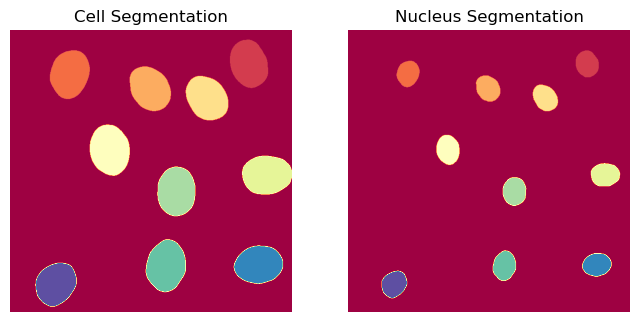

Values in mask:  [ 0  1  2  3  4  5  6  7  8  9 10]


In [4]:
from cellpose import models, plot

img_cyto_max = np.max(img[:, :, :, 1], axis = 0)
model1 = models.Cellpose(gpu = False, model_type = 'cyto')

# Apply the model to your image
masks_cyto, flows, styles, diams = model1.eval(img_cyto_max, diameter=None, channels=[0,0])
# Plotting each one of the 3 colors independently
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(masks_cyto,cmap='Spectral')
ax[0].axis('off')
ax[0].set_title('Cell Segmentation')
print('Values in mask: ', np.unique (masks_cyto))

img_nuc = img[0, :, :, 0]
model2 = models.Cellpose(gpu = False, model_type = 'nuclei')

# Apply the model to your image
masks_nuc, flows, styles, diams = model2.eval(img_nuc, diameter=None, channels=[0,0])
# Plotting each one of the 3 colors independently
ax[1].imshow(masks_nuc,cmap='Spectral')
ax[1].axis('off')
ax[1].set_title('Nucleus Segmentation')
plt.show()
print('Values in mask: ', np.unique (masks_nuc))

In [13]:
# Make sure that one cell has the same id in both masks
# Get the unique labels in the cell and nucleus masks
cell_labels = np.unique(masks_cyto)
nucleus_labels = np.unique(masks_nuc)

# Initialize the mapping table
mapping_table = {}

# Loop through each cell label
for cell_label in cell_labels:
    # Skip the background
    if cell_label == 0:
        continue

    # Get the mask for the current cell
    current_cell_mask = (masks_cyto == cell_label)

    # Loop through each nucleus label
    for nucleus_label in nucleus_labels:
        # Skip the background
        if nucleus_label == 0:
            continue

        # Get the mask for the current nucleus
        current_nucleus_mask = (masks_nuc == nucleus_label)

        # If the current cell and the current nucleus overlap, add them to the mapping table
        if np.any(current_cell_mask & current_nucleus_mask):
            mapping_table[cell_label] = nucleus_label
            break
updated_masks_nuc = masks_nuc.copy()

# Loop through each item in the mapping table
for cell_label, nucleus_label in mapping_table.items():
    # Update the nucleus label in the nucleus mask
    updated_masks_nuc[masks_nuc == nucleus_label] = cell_label
masks_nuc = updated_masks_nuc

calculate the number of mRNAs in each nuclei and cytoplasm

In [40]:
# mRNA identification
threshold_m = 0.025
cell_id = np.unique(masks_cyto)
t_total = img.shape[0]

df_m_c = pd.DataFrame()
df_m_n = pd.DataFrame()

df_m_c['cell id'] = cell_id[1:]
df_m_n['cell id'] = cell_id[1:]

for t in range(t_total):
    # get the area of a single mRNA
    mRNA = img[t, :, :, 2]
    mRNA_filtered = difference_of_gaussians(mRNA, low_sigma=1, high_sigma=5)

    mRNA_binary = mRNA_filtered.copy()
    mRNA_binary[mRNA_binary>=threshold_m] = threshold_m # Making spots above the threshold equal to the threshold value.
    mRNA_binary[mRNA_binary<threshold_m] = 0 # Making spots below the threshold equal to 0.

    mRNA_binary[mRNA_binary!=0] = 1 # Binarization

    spot_contours = measure.find_contours(mRNA_binary, 0.9)

    labels_m = measure.label(mRNA_binary)

    props = measure.regionprops(labels_m, intensity_image=mRNA)

    # Initialize a list to store the intensities
    areas = []

    # Loop through each mRNA in the image
    for prop in props:
        # Calculate the intensity of the current mRNA and add it to the list

        areas.append(prop.area)

    areas = np.array(areas)
    areas_sorted = np.sort(areas)
    start = np.percentile(areas_sorted, 10)
    end = np.percentile(areas_sorted, 50)
    selected_areas = areas_sorted[(areas_sorted>=start) & (areas_sorted<=end)]
    single_mRNA_area = np.mean(selected_areas)

    mRNA_num_cyto = []
    mRNA_num_nuc = []

    for id in cell_id:
        # Skip the background
        if id == 0:
            continue

        # Get the mask for the current cell
        nuc_mask = (masks_nuc == id)

        # Calculate the properties of the mRNAs in the current cell
        props_n = measure.regionprops(labels_m * nuc_mask, intensity_image = mRNA)

        # Initialize the total area, total intensity and count for the current cell
        total_area_n = 0
        count_n = 0

        # Loop through each mRNA in the current cell
        for prop in props_n:
            # Update the total area, total intensity and count
            total_area_n += prop.area

        count_n = round(total_area_n / single_mRNA_area)
        # Add the results for the current cell to the DataFrame

        mRNA_num_nuc.append(count_n)
        
        # Get the mask for the current cell
        mask_c = (masks_cyto == id)
        mask_n = (masks_nuc == id)
        cyto_mask = mask_c & ~mask_n

        # Calculate the properties of the mRNAs in the current cell
        props_c = measure.regionprops(labels_m * cyto_mask, intensity_image = mRNA)

        # Initialize the total area, total intensity and count for the current cell
        total_area_c = 0
        count_c = 0

        # Loop through each mRNA in the current cell
        for prop in props_c:
            # Update the total intensity and count
            total_area_c += prop.area

        count_c = round(total_area_c / single_mRNA_area)
        # Add the results for the current cell to the DataFrame

        mRNA_num_cyto.append(count_c)

    df_m_c['frame' + str(t+1)] = mRNA_num_cyto
    df_m_n['frame' + str(t+1)] = mRNA_num_nuc


In [44]:
df_m_n

,cell id,frame1,frame2,frame3,frame4,frame5,frame6,frame7,frame8,frame9,...,frame12,frame13,frame14,frame15,frame16,frame17,frame18,frame19,frame20,frame21
0,1,9,11,17,11,15,2,2,1,0,...,0,0,0,0,0,0,0,0,0,3
1,2,3,3,1,1,0,2,2,4,2,...,5,4,3,2,7,3,4,6,5,3
2,3,0,0,0,0,0,0,0,0,1,...,0,0,0,0,3,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,7,7,7,7,5,4,5,2,1,...,0,1,3,2,4,9,6,5,3,6
5,6,5,5,1,0,0,4,6,7,6,...,0,0,0,0,5,5,6,8,4,6
6,7,8,10,8,7,1,2,2,1,1,...,0,0,0,2,3,4,4,3,1,0
7,8,0,10,15,12,5,0,0,3,3,...,1,1,1,1,4,1,0,0,0,0
8,9,5,2,1,1,0,0,0,5,3,...,3,4,4,4,3,8,7,7,3,5
9,10,11,6,5,2,1,0,0,3,2,...,3,0,2,2,1,9,3,4,4,6


In [ ]:
# Save the DataFrame to a csv file
df_m_n.to_csv('mRNAs_in_nucleus.csv', index=False)
df_m_c.to_csv('mRNAs_in_cyto.csv', index=False)

number and intensity of transcription site in each cell

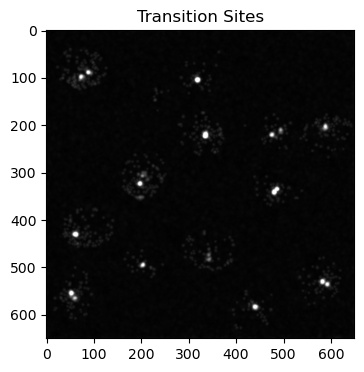

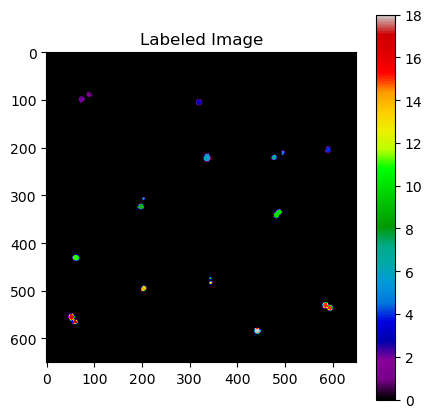

In [18]:
trans_site = np.max(img[:, :, :, 2], axis=0)

# Display the original image
plt.figure(figsize=(4, 4))
plt.imshow(trans_site, cmap='gray')
plt.title('Transition Sites')
plt.show()

# Apply a threshold to segment the transition sites
threshold = filters.threshold_otsu(trans_site)
binary_trans = trans_site > threshold

# Label connected components
labeled_trans, num_labels = ndi.label(binary_trans)

plt.figure(figsize=(5,5))
plt.imshow(labeled_trans, cmap='nipy_spectral')
plt.colorbar()
plt.title('Labeled Image')
plt.show()

In [19]:
# Initialize an empty DataFrame
df_trans = pd.DataFrame()

# Initialize an empty list to store the cell each region belongs to
cell_labels = []

# Loop over each frame in the image
for i in range(img.shape[0]):
    # Calculate the properties of each region for the current frame
    regions = measure.regionprops(labeled_trans, intensity_image=img[i,:,:,2])
    
    # Get the mean intensity of each region
    brightness = [(region.mean_intensity)*(region.area) for region in regions]
    
    # Add the brightness values to the DataFrame
    df_trans['frame'+str(i+1)] = brightness

# Loop over each region
for region in regions:
    # Get the coordinates of the region
    coords = region.coords
    
    # Get the labels of the cells that the region belongs to in masks_cyto
    labels = masks_cyto[coords[:,0], coords[:,1]]
    
    # Get the most common label, which is the cell that the region belongs to
    cell_label = np.argmax(np.bincount(labels))
    
    # Add the cell label to the list
    cell_labels.append(cell_label)

# Add the cell labels to the DataFrame
df_trans.insert(0, 'cell', cell_labels)

df_trans

,cell,frame1,frame2,frame3,frame4,frame5,frame6,frame7,frame8,frame9,...,frame12,frame13,frame14,frame15,frame16,frame17,frame18,frame19,frame20,frame21
0,1,2721.0,17650.0,8137.0,6453.0,13746.0,9311.0,6912.0,3483.0,2725.0,...,2924.0,2685.0,2616.0,2953.0,2731.0,2354.0,2790.0,3057.0,2698.0,10788.0
1,1,8564.0,6210.0,18668.0,9978.0,4189.0,3096.0,3189.0,3232.0,2811.0,...,3067.0,3143.0,2980.0,3302.0,3053.0,2884.0,3417.0,3394.0,3044.0,2936.0
2,2,7911.0,5454.0,4349.0,3706.0,3680.0,6318.0,5035.0,6449.0,6266.0,...,18230.0,8900.0,8310.0,4394.0,16188.0,10705.0,11544.0,26823.0,18649.0,7679.0
3,7,18541.0,13780.0,6634.0,3750.0,2942.0,6400.0,5619.0,3800.0,4283.0,...,3357.0,3281.0,3596.0,9191.0,7785.0,9167.0,8646.0,5604.0,4607.0,3296.0
4,6,2757.0,2855.0,1935.0,1421.0,1439.0,1576.0,6972.0,5382.0,2208.0,...,1521.0,1655.0,1436.0,1340.0,1501.0,1304.0,1220.0,1638.0,1451.0,3629.0
5,5,11636.0,11497.0,5648.0,9696.0,6034.0,30217.0,15049.0,7623.0,6434.0,...,4902.0,6281.0,11896.0,9604.0,13134.0,31336.0,15044.0,9432.0,11466.0,30264.0
6,6,4095.0,3285.0,2634.0,2768.0,2686.0,7903.0,4098.0,13450.0,6209.0,...,2413.0,2476.0,2485.0,2475.0,10077.0,5385.0,15950.0,7548.0,5764.0,3711.0
7,8,735.0,3124.0,2720.0,1750.0,642.0,673.0,687.0,651.0,692.0,...,650.0,604.0,697.0,701.0,694.0,644.0,670.0,688.0,685.0,733.0
8,8,3064.0,20955.0,10686.0,6272.0,4464.0,2908.0,3283.0,6623.0,5473.0,...,3817.0,3686.0,3950.0,4136.0,9319.0,3889.0,3165.0,3213.0,2901.0,2963.0
9,9,8178.0,6519.0,5475.0,5625.0,6306.0,5815.0,5755.0,12508.0,9664.0,...,6807.0,13170.0,21001.0,9470.0,8014.0,31872.0,30546.0,13072.0,16598.0,29242.0


In [37]:
# Count the number of transcription sites for each cell
transcription_sites_per_cell = df_trans['cell'].value_counts()
for i in cell_id[1:]:
    if i not in transcription_sites_per_cell.index:
        transcription_sites_per_cell[i] = 0
sorted_trans = transcription_sites_per_cell.sort_index()
num_trans = sorted_trans.tolist()

In [ ]:
# Save the DataFrame to a csv file
df_trans.to_csv('trans.csv', index=False)

Cell size, nucleus size and number of transcription sites

In [38]:
cell_size = []
nucleus_size = []
trans_num = []

cell_id = np.unique(masks_cyto)
nucleus_id = np.unique(masks_nuc)

for id in cell_id:
    if id == 0:
        continue
    cell_size.append(np.sum(masks_cyto == id))

for id in nucleus_id:
    if id == 0:
        continue
    nucleus_size.append(np.sum(masks_nuc == id))

df_info = pd.DataFrame({
    'cell_id': cell_id[1:],
    'cell_size': cell_size,
    'nucleus_size': nucleus_size,
    'trans_num': num_trans,
})
df_info

,cell_id,cell_size,nucleus_size,trans_num
0,1,7198,3032,2
1,2,7839,3319,1
2,3,7148,3054,0
3,4,6476,2837,0
4,5,7061,3152,1
5,6,7804,3291,2
6,7,7438,3336,1
7,8,7366,3237,2
8,9,8061,3368,1
9,10,7302,3172,1


In [30]:
df_info.to_csv('Basic_Information.csv', index=False)

13

Protein Intensity

In [ ]:
#Protein Intensity
#createDataFrame
df_protein = pd.DataFrame()

# t_total = img.shape[0]

for t in range(t_total):
     # If the frame has multiple channels, use only the first channel
    frame = img[t, :, :, 1]
    df_protein['cell id'] = np.nan
    df_protein['frame'+str(t+1)] = np.nan
    # Get unique cell masks
    unique_masks = np.unique(masks_cyto)
    
    # Loop through each unique mask (cell)
    for cell_id in unique_masks:
        if cell_id == 0:
            continue  # Skip background
        
        # Create a mask for the current cell
        cell_mask = (masks_cyto == cell_id).astype(np.uint8)
        
        # Check the sizes of the frame and cell_mask
        if frame.shape != cell_mask.shape:
            print(f"Size mismatch: frame shape {frame.shape}, cell_mask shape {cell_mask.shape}")
            continue
        
        # Calculate the mean intensity of the current cell
        total_intensity = np.sum(frame * cell_mask)
        area = np.sum(cell_mask)
        mean_intensity = total_intensity / area if area > 0 else 0
        
        # Append the results to the list
        df_protein.loc[cell_id-1, 'cell id'] = int(cell_id)
        df_protein.loc[cell_id-1, 'frame'+str(t+1)] = mean_intensity

# Save the DataFrame
df_protein.to_csv('protein_intensity.csv', index=False)